In [1]:
# imports

import cv2
from matplotlib import pyplot as plt
import numpy as np
import util_functions as uf
import open3d as o3d
from scipy.optimize import minimize
import time
import os
import shutil
from ultralytics import YOLO
import json
import argparse
import datetime
import csv
import pandas as pd
import seaborn as sns
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
from scipy.spatial import cKDTree
import random
from scipy.spatial.transform import Rotation
import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Helper Functions

In [ ]:
# helper functions


def ViewSegments(rgb_img, mask, blend_value=0.4, show=True, save=True, debug=False):
    """
    Visualize the segment results on the image.
    Inputs:
    1. rgb_img (string): Path to the RGB image
    2. results (list): List of segment results
    3. mask_num (int): Mask number to visualize
    4. blend_value (float): Blending value for the mask overlay on image
    5. show (bool): Show the image
    6. save (bool): Save the image
    Outputs:
    1. scaled_mask (np.ndarray): Scaled mask
    2. blended_image_rgb (np.ndarray): Blended image
    """
    image = cv2.imread(rgb_img)
    print("Mask shape: ", mask.shape) if debug else None
    scaled_mask = ScaleMask(mask, image.shape)
    if len(scaled_mask.shape) == 3 and scaled_mask.shape[2] == 1:
        scaled_mask = scaled_mask[:, :, 0]
    print("Scaled mask shape: ", scaled_mask.shape) if debug else None
    colored_mask = cv2.applyColorMap((scaled_mask * 255).astype(np.uint8), cv2.COLORMAP_JET)
    # Overlaying the mask on the image using blending
    blended_image = cv2.addWeighted(image, 1, colored_mask, blend_value, 0)
    blended_image_rgb = cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB)

    if show:
        plt.imshow(blended_image_rgb)
        plt.axis('off')
        plt.show()
    
    if save:
        cv2.imwrite(f"data/segmented_image.jpg", blended_image_rgb)

    return scaled_mask, blended_image_rgb



def YOLOInference(img):
    """
    Perform inference using the trained YOLO model.
    Inputs:
    1. img: Path to image
    """
    model = YOLO("yolo_model.pt")

    return model(img)


def createSegmentPCL(rgb_img, depth_img, mask, show=False):
    fx, fy = cam_intrinsics[0], cam_intrinsics[1]
    cx, cy = cam_intrinsics[2], cam_intrinsics[3]
    depth_scale = 1000.0  # assuming depth is in millimeters

    indices = np.where(mask > 0)
    u_coords, v_coords = indices[1], indices[0]  # (x, y) = (col, row)
    z = depth_img[v_coords, u_coords].astype(np.float32) / depth_scale
    x = (u_coords - cx) * z / fx
    y = (v_coords - cy) * z / fy

    valid = z > 0
    points = np.stack((x[valid], y[valid], z[valid]), axis=-1)

    colors = rgb_img[v_coords[valid], u_coords[valid]].astype(np.float32) / 255.0

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)

    if show:
        visPCL(pcd, pcl_is_array=False, cam_frame=True, is_color=True)

    return pcd

def visPCL(pcl, pcl_is_array, cam_frame=True, is_color=False): 
    """
    Visualizes the input point cloud.
    
    Parameters:
    - pcl: open3d.geometry.PointCloud or numpy.ndarray of shape (N, 3)
    - pcl_is_array: True if pcl is a numpy array
    - cam_frame: whether to show the camera coordinate frame
    - is_color: whether to use color info (if available in pcl)
    """
    if pcl_is_array:
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(pcl)
        if is_color:
            try:
                colors = np.load("obj_FINAL1_data/segment_pts_3D_color.npy")
                pcd.colors = o3d.utility.Vector3dVector(colors)
            except FileNotFoundError:
                print("Color file not found. Visualizing without color.")
        pcl = pcd

    geometries = [pcl]
    if cam_frame:
        camera_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.05)
        camera_frame.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
        geometries.append(camera_frame)

    o3d.visualization.draw_geometries(geometries)

def save_open3d_scene(geometries, folder_path):
    """
    Saves a list of Open3D geometries and the current camera parameters
    into the specified folder.
    TriangleMesh → .ply  
    PointCloud  → .ply  
    LineSet     → .json (manually serialized)  
    Camera params → camera.json  
    """
    os.makedirs(folder_path, exist_ok=True)

    # 1) Save each geometry
    for idx, geo in enumerate(geometries):
        if isinstance(geo, o3d.geometry.TriangleMesh):
            path = os.path.join(folder_path, f"mesh_{idx}.ply")
            o3d.io.write_triangle_mesh(path, geo)
        elif isinstance(geo, o3d.geometry.PointCloud):
            path = os.path.join(folder_path, f"pointcloud_{idx}.ply")
            o3d.io.write_point_cloud(path, geo)
        elif isinstance(geo, o3d.geometry.LineSet):
            # CHANGED: manually serialize LineSet → JSON
            path = os.path.join(folder_path, f"lineset_{idx}.json")
            data = {
                "points":  np.asarray(geo.points).tolist(),
                "lines":   np.asarray(geo.lines).tolist(),
                "colors":  (np.asarray(geo.colors).tolist()
                            if geo.has_colors() else None)
            }
            with open(path, "w") as f:
                json.dump(data, f, indent=2)
        else:
            print(f"[Warning] Skipping unsupported geometry type {type(geo)} at index {idx}")

    # 2) Capture & save the current camera
    vis = o3d.visualization.Visualizer()
    vis.create_window(visible=False)
    for geo in geometries:
        vis.add_geometry(geo)
    vis.poll_events()
    vis.update_renderer()
    cam_params = vis.get_view_control().convert_to_pinhole_camera_parameters()
    cam_path = os.path.join(folder_path, "camera.json")
    o3d.io.write_pinhole_camera_parameters(cam_path, cam_params)
    vis.destroy_window()

def generate_good_edges(mode=1, seed=None):
    """
    Generate a good_edges list of length 4 based on the selected mode.

    Modes:
        1: adjacent pair are good (e.g., [1,1,0,0])
        2: any random combination (e.g., [1,0,1,0])
        3: three adjacent edges are good (e.g., [1,1,1,0])
        4: opposite pairs are good (e.g., [1,0,1,0] or [0,1,0,1])
        5: only one random edge is good (e.g., [0,0,1,0])

    Args:
        mode (int): mode number from 1 to 5
        seed (int or None): optional seed for reproducibility

    Returns:
        list of 0s and 1s of length 4
    """
    if seed is not None:
        random.seed(seed)

    good_edges = [0, 0, 0, 0]

    if mode == 1:
        start = random.randint(0, 3)
        good_edges[start] = 1
        good_edges[(start + 1) % 4] = 1

    elif mode == 2:
        good_edges = [random.choice([0, 1]) for _ in range(4)]

    elif mode == 3:
        start = random.randint(0, 3)
        good_edges[start] = 1
        good_edges[(start + 1) % 4] = 1
        good_edges[(start + 2) % 4] = 1

    elif mode == 4:
        pair = random.choice([(0, 2), (1, 3)])
        good_edges[pair[0]] = 1
        good_edges[pair[1]] = 1

    elif mode == 5:
        idx = random.randint(0, 3)
        good_edges[idx] = 1

    else:
        raise ValueError("Invalid mode. Choose an integer from 1 to 5.")

    return good_edges

def get_noisy_edges(good_edges):
    """
    Returns the indices of the edges which are bad (value 0 in good_edges)
    """
    return [i for i, val in enumerate(good_edges) if val == 0]

def get_edge_weights(good_edges, good_weight=0.9):
    """
    Returns a list of weights based on good_edges and the specified good_weight.
    Bad edges receive a weight of (1 - good_weight).
    """
    return [good_weight if val == 1 else 1.0 - good_weight for val in good_edges]

def biased_mode_choice(probabilities=None):
    """
    Randomly selects a mode from [1, 3, 4, 5] with the following probabilities:
        - 1: 50%
        - 3: 30%
        - 4: 15%
        - 5: 5%
    Returns:
        int: one of [1, 3, 4, 5]
    """
    modes = [1, 3, 4, 5]
    if probabilities is None:
        # Default probabilities
        probabilities = [0.6, 0.35, 0.1, 0.05]
    else:
        # Ensure the probabilities sum to 1
        total = sum(probabilities)
        probabilities = [p / total for p in probabilities]
    return random.choices(modes, weights=probabilities, k=1)[0]

def clean_segment_mask(segment):
    """
    Keeps only the largest contour in the binary segmentation mask.
    Args:
        segment (np.ndarray): Binary mask with 0s and 1s.
    Returns:
        np.ndarray: Cleaned binary mask with only the largest blob retained.
    """
    # Convert mask to uint8 (required by OpenCV)
    mask_uint8 = (segment * 255).astype(np.uint8)

    # Find all external contours
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) <= 1:
        return segment  # Nothing to clean

    # Find the largest contour by area
    largest_contour = max(contours, key=cv2.contourArea)

    # Create a new blank mask and draw only the largest contour
    cleaned_mask = np.zeros_like(mask_uint8)
    cv2.drawContours(cleaned_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    # Convert back to binary 0/1 mask
    return (cleaned_mask > 0).astype(np.uint8)


def randomize_contour_lines2(
    contour_lines,
    edge_indices,
    noise_type='gaussian',
    noise_level=1.0,
    poly_degree=3,
    shift=None,
    angle=None
):
    """
    Randomize selected contour lines.

    Parameters
    ----------
    contour_lines : list of (Ni×2) arrays
        Original contour points for each of the four edges.
    edge_indices : list of ints
        Indices (0–3) of edges to randomize.
    noise_type : {'gaussian','poly'}
        Type of point‐wise noise.
    noise_level : float
        - gaussian: standard deviation in pixels
        - poly: std. dev. of polynomial coefficients
    poly_degree : int
        Degree of polynomial for 'poly' noise.
    shift : float or None
        Global shift magnitude along the contour's normal. If None, 
        sampled as N(0, noise_level).
    angle : float (radians) or None
        Global rotation about contour centroid. If None, sampled as
        N(0, noise_level * 0.1).
    """
    randomized = []
    for idx, pts in enumerate(contour_lines):
        pts = pts.astype(float)
        if idx not in edge_indices:
            randomized.append(pts)
            continue

        # determine random or fixed shift & angle
        if shift is None:
            shift_val = np.random.normal(scale=noise_level)
        else:
            shift_val = shift
        if angle is None:
            angle_val = np.random.normal(scale=noise_level * 0.1)
        else:
            angle_val = angle

        # compute centroid once
        centroid = pts.mean(axis=0)

        # 1) apply point‐wise noise
        if noise_type == 'gaussian':
            noise = np.random.normal(scale=noise_level, size=pts.shape)
            new_pts = pts + noise

        elif noise_type == 'poly':
            # PCA to get principal direction & normal
            U, S, Vt = np.linalg.svd(pts - centroid)
            d = Vt[0]
            n = np.array([-d[1], d[0]])
            # ensure normal direction is random sign
            if np.random.rand() < 0.5:
                n = -n

            t = (pts - centroid) @ d
            # normalize t to [0,1]
            t_norm = (t - t.min()) / (t.max() - t.min() + 1e-8)

            # random polynomial coefficients
            coeffs = np.random.normal(scale=noise_level, size=poly_degree+1)
            coeffs[0] = 0
            T = np.vstack([t_norm**k for k in range(poly_degree+1)])
            disp = coeffs @ T

            new_pts = centroid + np.outer(t, d) + np.outer(disp, n)

        else:
            raise ValueError(f"Unknown noise_type '{noise_type}'")

        # 2) apply global shift along normal
        # redo PCA on new_pts to get its normal direction
        U2, S2, Vt2 = np.linalg.svd(new_pts - new_pts.mean(axis=0))
        d2 = Vt2[0]
        n2 = np.array([-d2[1], d2[0]])
        new_pts += n2 * shift_val

        # 3) apply global rotation about centroid
        c = new_pts.mean(axis=0)
        R = np.array([
            [np.cos(angle_val), -np.sin(angle_val)],
            [np.sin(angle_val),  np.cos(angle_val)]
        ])
        new_pts = (R @ (new_pts - c).T).T + c

        randomized.append(new_pts)

    return randomized

def reorder_edges_to_brtl(cntr_list):
    """
    Given a list of up to 4 arrays (Ni×2) in normalized coords,
    returns [bottom, right, top, left], even if some are empty.
    """
    # centroids: empty arrays get NaNs
    centroids = []
    for pts in cntr_list:
        if pts.size:
            centroids.append(np.mean(pts, axis=0))
        else:
            centroids.append(np.array([np.nan, np.nan]))
    xs = [c[0] for c in centroids]
    ys = [c[1] for c in centroids]

    order = [
        int(np.nanargmax(ys)),  # bottom = max y
        int(np.nanargmax(xs)),  # right  = max x
        int(np.nanargmin(ys)),  # top    = min y
        int(np.nanargmin(xs))   # left   = min x
    ]
    return [cntr_list[i] for i in order]


def ptsToNormImageCoords(points_px, adjust_px_offset=True):
    """
    Convert pixel coordinates to normalized image coordinates.
    Args:
        points_px (np.ndarray): (N, 2) array of pixel coordinates (u, v).
    Returns:
        np.ndarray: (N, 2) array of normalized coordinates (x, y).
    """
    fx, fy, cx, cy = cam_intrinsics[0], cam_intrinsics[1], cam_intrinsics[2], cam_intrinsics[3]
    points_px = np.asarray(points_px)
    if adjust_px_offset:
        u = points_px[:, 0] #+ 0.5
        v = points_px[:, 1] #+ 0.5
    else:
        u = points_px[:, 0]
        v = points_px[:, 1]
    #v = (h - 1) - v  # flip y-axis before normalizing
    x_n = (u - cx) / fx
    y_n = (v - cy) / fy
    return np.stack((x_n, y_n), axis=1)


def is_box_vertical3D(contour_sets, pts3d):
    """
    contour_sets: list of 4 arrays of shape (Ni,2) in normalized image coords
    pts3d:        (M,3) array of segmentation points in camera coords
    Returns True if, in 3D, the summed vertical edge extents exceed horizontal extents.
    """

    # 1) Build KD-tree of normalized 3D points
    #    normalized coords: (X/Z, Y/Z)
    valid = pts3d[:,2] > 1e-6
    xyz   = pts3d[valid]
    norms = xyz[:,:2] / xyz[:,2:3]
    kdtree = cKDTree(norms)

    # 2) Reorder into bottom, right, top, left by 2D centroids
    brtl = reorder_edges_to_brtl(contour_sets)
    bottom2d, right2d, top2d, left2d = brtl

    # 3) Map each 2D contour to 3D points via nearest‐neighbor lookup
    def lift_to_3d(pts2d):
        if pts2d.size == 0:
            return np.empty((0,3))
        _, idxs = kdtree.query(pts2d, k=1)
        return xyz[idxs]

    bottom3d = lift_to_3d(bottom2d)
    top3d    = lift_to_3d(top2d)
    right3d  = lift_to_3d(right2d)
    left3d   = lift_to_3d(left2d)

    # 4) Compute 3D extents along camera X (width) and Y (height)
    def extent_along_axis(pts3d, axis):
        if pts3d.size == 0:
            return 0.0
        coords = pts3d[:, axis]
        return coords.max() - coords.min()

    width_extent  = extent_along_axis(bottom3d, 0) + extent_along_axis(top3d, 0)
    height_extent = extent_along_axis(right3d, 1)  + extent_along_axis(left3d, 1)
    print("segmentation point cloud width_extent:", width_extent)
    print("segmentation point cloud height_extent:", height_extent)

    # 5) Vertical if height > width
    return height_extent > width_extent, height_extent, width_extent


def R_from_quat(q):
    w,x,y,z = q
    return np.array([
      [1-2*(y*y+z*z), 2*(x*y - z*w), 2*(x*z + y*w)],
      [2*(x*y + z*w), 1-2*(x*x+z*z), 2*(y*z - x*w)],
      [2*(x*z - y*w), 2*(y*z + x*w), 1-2*(x*x+y*y)]
    ])


def quat_from_two_vectors(v0, v1, eps=1e-6):
    """
    Return unit quaternion q = [w,x,y,z] that rotates v0 → v1.
    """
    v0 = v0 / np.linalg.norm(v0)
    v1 = v1 / np.linalg.norm(v1)
    dot = np.dot(v0, v1)
    if dot < -1 + eps:
        # 180° rotation: find an orthogonal axis
        axis = np.cross(np.array([1,0,0]), v0)
        if np.linalg.norm(axis) < eps:
            axis = np.cross(np.array([0,1,0]), v0)
        axis /= np.linalg.norm(axis)
        return np.array([0.0, *axis])  # w=0, (x,y,z)=axis
    axis = np.cross(v0, v1)
    s = np.sqrt((1 + dot) * 2)
    w = 0.5 * s
    xyz = axis / s
    return np.array([w, xyz[0], xyz[1], xyz[2]])


def visualize_fullpose(
    params,
    B_corners, pts3d, pts3d_color,
    fx, fy, cx, cy, w, h,
    frame_size=0.1,
    plane_size=0.8,
    sphere_radius=0.005,
    sphere_offset=0.02,                  # distance beyond arrow tip
    box_frame_color=(0.7, 0.7, 0.7),     # uniform frame color
    cam_frame_color=(0.7, 0.7, 0.7),     # uniform frame color
    plane_color=(0.2, 0.2, 0.2),         # plane color
    obs_corner_color=(1, 0, 0),          # observed corners color
    mod_corner_color=(0, 1, 0)           # model corners color
):
    """
    params = [a1,b1,c1,..,a4,b4,c4, qw,qx,qy,qz, tx,ty,tz, nx,ny,nz,-d]
    Returns:
      R, t_cam,
      cam_frame, box_frame,
      plane, seg, quad_obs, quad_mod,
      axis_spheres, obs_spheres, mod_spheres
    """
    # Unpack
    abc         = np.array(params[0:12]).reshape(4,3)
    qw,qx,qy,qz = params[12:16]
    t_cam       = np.array(params[16:19])
    nx,ny,nz,dp = params[19:23]

    # Normalize plane normal
    ep = np.array([nx, ny, nz, dp], float)
    ep[:3] /= np.linalg.norm(ep[:3])
    n = ep[:3]

    # Observed corners via triple-plane intersection
    corners_obs = []
    for i in range(4):
        a, b, c    = abc[i]
        a2, b2, c2 = abc[(i+1)%4]
        e1 = np.array([ a, -b, -c, 0.0])
        e2 = np.array([a2,-b2,-c2,0.0])
        A  = np.vstack((e1[:3], e2[:3], ep[:3]))
        bv = np.array([-e1[3], -e2[3], -ep[3]])
        P  = np.linalg.solve(A, bv)
        corners_obs.append(P)
    corners_obs = np.array(corners_obs)

    # Model corners from B_corners

    # If the box was rotated around its local Z-axis by +90°, undo it for B_corners
    if is_vertical:
        # Inverse rotation: -90° around Z
        rot_z_minus_90 = Rotation.from_euler('z', -90, degrees=True)
        B_corners = (rot_z_minus_90.as_matrix() @ B_corners.T).T

    def R_from_quat(q):
        w,x,y,z = q
        return np.array([
            [1-2*(y*y+z*z), 2*(x*y - z*w), 2*(x*z + y*w)],
            [2*(x*y + z*w), 1-2*(x*x+z*z), 2*(y*z - x*w)],
            [2*(x*z - y*w), 2*(y*z + x*w), 1-2*(x*x+y*y)]
        ])
    q = np.array([qw,qx,qy,qz], float)
    q /= np.linalg.norm(q)
    R = R_from_quat(q)
    # Combine 180° rotations around Z then X axes (local frame)
    R_z_180 = Rotation.from_euler('z', 180, degrees=True).as_matrix()
    R_x_180 = Rotation.from_euler('x', 180, degrees=True).as_matrix()
    R_z_90 = Rotation.from_euler('z', 90, degrees=True).as_matrix()
    # Apply both rotations in sequence: first Z, then X
    #R = R @ R_z_180 @ R_x_180
    #R = R @ R_z_90

    corners_mod = (R @ B_corners.T).T + t_cam

    # FLIP for Open3D coordinates
    FLIP4 = np.eye(4)
    FLIP4[:3,:3] = np.diag([1, -1, -1])

    P_o3d   = (FLIP4[:3,:3] @ corners_obs.T).T
    Q_o3d   = (FLIP4[:3,:3] @ corners_mod.T).T
    pts_o3d = (FLIP4[:3,:3] @ pts3d.T).T

    # Camera‐to‐world in O3D frame
    R_o3d = FLIP4[:3,:3] @ R @ FLIP4[:3,:3]
    t_o3d = FLIP4[:3,:3] @ t_cam

    # Prepare separate lists for spheres
    axis_spheres = []   # CHANGED: for frame‐axis end spheres
    obs_spheres  = []   # CHANGED: for observed corner spheres
    mod_spheres  = []   # CHANGED: for model corner spheres

    # 1) Camera frame mesh
    cam_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=frame_size)
    cam_frame.rotate(FLIP4[:3,:3])
    cam_frame.paint_uniform_color(cam_frame_color)

    # 2) Axis‐tip spheres for camera frame
    axis_dirs = [np.array([1,0,0]), np.array([0,1,0]), np.array([0,0,1])]
    axis_cols = [(1,0,0), (0,1,0), (0,0,1)]
    cam_origin = np.zeros(3)
    for d, col in zip(axis_dirs, axis_cols):
        axis_vec_cam = FLIP4[:3,:3] @ d
        pos = cam_origin + axis_vec_cam * (frame_size + sphere_offset)
        sph = o3d.geometry.TriangleMesh.create_sphere(radius=0.00001)
        sph.compute_vertex_normals()
        sph.paint_uniform_color(col)
        sph.translate(pos)
        axis_spheres.append(sph)

    # 3) Box frame mesh
    box_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=frame_size)
    T_box = np.eye(4)
    T_box[:3,:3] = R_o3d
    T_box[:3, 3] = t_o3d
    box_frame.transform(T_box)
    box_frame.paint_uniform_color(box_frame_color)

    # 4) Axis‐tip spheres for box frame
    for d, col in zip(axis_dirs, axis_cols):
        axis_vec_box = R_o3d @ d
        pos = t_o3d + axis_vec_box * (frame_size + sphere_offset)
        sph = o3d.geometry.TriangleMesh.create_sphere(radius=sphere_radius)
        sph.compute_vertex_normals()
        sph.paint_uniform_color(col)
        sph.translate(pos)
        axis_spheres.append(sph)

    # 5) Observed corner spheres
    for pt in P_o3d:
        sph = o3d.geometry.TriangleMesh.create_sphere(radius=sphere_radius)
        sph.compute_vertex_normals()
        sph.paint_uniform_color(obs_corner_color)
        sph.translate(pt)
        obs_spheres.append(sph)

    # 6) Model corner spheres
    for pt in Q_o3d:
        sph = o3d.geometry.TriangleMesh.create_sphere(radius=sphere_radius)
        sph.compute_vertex_normals()
        sph.paint_uniform_color(mod_corner_color)
        sph.translate(pt)
        mod_spheres.append(sph)

    # 7) Quads
    def make_quad(pts, color):
        ls = o3d.geometry.LineSet(
            points=o3d.utility.Vector3dVector(pts),
            lines=o3d.utility.Vector2iVector([[0,1],[1,2],[2,3],[3,0]])
        )
        ls.colors = o3d.utility.Vector3dVector([color]*4)
        return ls
    quad_obs = make_quad(P_o3d, obs_corner_color)
    quad_mod = make_quad(Q_o3d, mod_corner_color)

    # 8) Translucent plane centered at pose origin
    a_vec = np.array([1,0,0])
    if abs(a_vec.dot(n)) > 0.9:
        a_vec = np.array([0,1,0])
    u = np.cross(n, a_vec); u /= np.linalg.norm(u)
    v = np.cross(n, u)
    center = t_cam
    verts = [
        center + du*plane_size*u + dv*plane_size*v
        for du,dv in [(-1,-1),(-1,1),(1,1),(1,-1)]
    ]
    verts_o3d = [(FLIP4[:3,:3] @ v).tolist() for v in verts]
    plane = o3d.geometry.TriangleMesh(
        vertices=o3d.utility.Vector3dVector(verts_o3d),
        triangles=o3d.utility.Vector3iVector([[0,2,1],[0,3,2]])
    )
    plane.paint_uniform_color(plane_color)
    plane.compute_vertex_normals()
    plane.translate(0.007 * n)  # offset for visibility)

    # 9) Segmentation cloud
    seg = o3d.geometry.PointCloud()
    seg.points = o3d.utility.Vector3dVector(pts_o3d)
    seg.colors = o3d.utility.Vector3dVector(pts3d_color)
    seg.translate(0.005 * n)  # offset for visibility

    # Return everything; caller decides what to draw
    return (
        R, t_cam,
        cam_frame, box_frame,
        plane, seg, quad_obs, quad_mod,
        axis_spheres, obs_spheres, mod_spheres
    )



## Main

In [26]:
# Metadata ------------------------------------------------------------------------------------

mask_number = 3
image_num = 3
cam_intrinsics = [729.7567138671875, 729.7567138671875, 965.4871826171875, 553.424072265625] # camera intrinsics in the format [fx, fy, cx, cy]
CONTOUR_NOISE = False # if True, add noise to the contours for evaluation purposes
generate_random = False # if True, generate random noise for evaluation purposes
all_edges_good = True # if True, all edges are good and no noise is applied
runYOLO = True # if True, run YOLO to get initial segmentations
known_dims = True # if True, use the known object dimensions for optimization
test_dataset = True # if True, use the test dataset (from the folder "new_data")
log = False # if True, log optimization results at each iteration, but slows down the process

cntr_line_weights = np.array([0.25, 0.25, 0.25, 0.25], dtype=float) # weight for each edge in the first residual (contour line fitting)
final_weights = np.array([0.6, 1.8, 0.6], dtype=float) # weights for each residual term

# ensuring the weights are normalized
final_weights /= np.sum(final_weights)
cntr_line_weights /= np.sum(cntr_line_weights)

now = datetime.datetime.now()
date_time = now.strftime("%Y%m%d_%H%M%S") # getting current date and time for unique folder names

records = [] # json records for important information
records.append({
    "mask_number" : mask_number,
    "image_num" : image_num,
    "contour_noise" : CONTOUR_NOISE,
    "generate_random" : generate_random,
    "all_edges_good" : all_edges_good,
})

In [ ]:
# Data Preparation ---------------------------------------------------------------------------

data_list = ["20251105_135131_733", "20251105_135415_228", "20251105_135807_229"]


# Dataset: rgb image, depth map, info file
rgb_path = f"volker_data_capture/varied_objects/{data_list[1]}/rgb.png"
depth_path = f"volker_data_capture/varied_objects/{data_list[1]}/depth.png"
info_csv = ""
crop_pts = [(174, 311), (243, 118), (391, 122), (443, 326)] # (x,y) tuples for cropping the image

# clean the folder before proceding 
data_folder = "obj_FINAL1_data"
permanent_folder = "permanent_data"
for item in os.listdir(data_folder):
    item_path = os.path.join(data_folder, item)
    if os.path.basename(item_path) != permanent_folder:
        if os.path.isdir(item_path):
            shutil.rmtree(item_path)
        else:
            os.remove(item_path)

if test_dataset:
    # choose the dataset automatically based on image_num
    datasets = {
        # image 2
        2: {
            "rgb": "new_data/2025_02_24___12_28_15_rgb.jpg",
            "depth": "new_data/2025_02_24___12_28_15_depth.png",
            "info": "new_data/2025_02_24___12_28_15_request.csv",
            "crop_pts": [(93, 992), (684, 186), (1207, 181), (1846, 992)],
        },
        # image 3
        3: {
            "rgb": "new_data/2025_02_27___12_37_07_239_rgb.jpg",
            "depth": "new_data/2025_02_27___12_37_07_239_depth.png",
            "info": "new_data/2025_02_27___12_37_07_239_request.csv",
            "crop_pts": [(720, 190), (240, 895), (1680, 910), (1190, 190)],
        },
        # image 4
        4: {
            "rgb": "new_data/2025_02_26___16_00_41_665_rgb.jpg",
            "depth": "new_data/2025_02_26___16_00_41_665_depth.png",
            "info": "new_data/2025_02_26___16_00_41_665_request.csv",
            "crop_pts": [(167, 954), (704, 193), (1171, 193), (1683, 943)],
        },
        # image 5
        5: {
            "rgb": "new_data/2025_02_24___13_00_01_rgb.jpg",
            "depth": "new_data/2025_02_24___13_00_01_depth.png",
            "info": "new_data/2025_02_24___13_00_01_request.csv",
            "crop_pts": [(70, 998), (715, 179), (1187, 179), (1803, 998)],
        },
        # image 6 (use v3 by default)
        6: {
            "rgb": "new_data/2025_02_25___15_32_18_rgb.jpg",
            "depth": "new_data/2025_02_25___15_32_18_depth.png",
            "info": "new_data/2025_02_25___15_32_18_request.csv",
            "crop_pts": [(1, 162), (1191, 164), (1620, 866), (0, 853)],
        },
        # image 7
        7: {
            "rgb": "new_data/2025_03_04___12_36_32_642_rgb.jpg",
            "depth": "new_data/2025_03_04___12_36_32_642_depth.png",
            "info": "new_data/2025_03_04___12_36_32_642_request.csv",
            "crop_pts": [(12, 63), (17, 1071), (1911, 1075), (1896, 82)],
        },
    }

    if image_num in datasets:
        entry = datasets[image_num]
        rgb_path = entry['rgb']
        depth_path = entry['depth']
        info_csv = entry['info']
        crop_pts = entry['crop_pts']
    else:
        raise ValueError(f"image_num {image_num} not found in datasets. Available: {list(datasets.keys())}")

    if known_dims:
        df = pd.read_csv(info_csv, header=2)
        box_dimensions = df[['Case_Dimension_1', 'Case_Dimension_2', 'Case_Dimension_3']].to_numpy().flatten()
        print("Known dimensions: ", box_dimensions)
    # ------------------------------------------------------------------------------


rgb_img = cv2.imread(rgb_path)
depth_img = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
img = cv2.imread(rgb_path)
original_img = img.copy()
mask = np.zeros_like(img)
roi_corners = np.array([crop_pts], dtype=np.int32)
cv2.fillPoly(mask, roi_corners, (255, 255, 255))
img = cv2.bitwise_and(original_img, mask)
rgb_path = "obj_FINAL1_data/cropped.jpg"
cv2.imwrite(rgb_path, img)

# save folder string
save_dir = f"obj_FINAL1_evaluation/image_{image_num}/mask_{mask_number}_experim_{date_time}"
masks_dir = f"obj_FINAL1_data/permanent_data/YOLO_results/image_{image_num}"
# create folder if not exists
os.makedirs(save_dir, exist_ok=True)
os.makedirs(masks_dir, exist_ok=True)

csv_path = f"obj_FINAL1_evaluation/image_{image_num}/poses_and_bboxes.csv"

if runYOLO:
    results = YOLOInference("obj_FINAL1_data/cropped.jpg")
    masks = results[0].masks.data.cpu().numpy()
    print(type(masks))
    print("number of masks: ", masks.shape)
    for i, mask in enumerate(masks):
        np.save(masks_dir + f"/mask_{i}.npy", mask)
    #exit(0)

mask = np.load(masks_dir + f"/mask_{mask_number}.npy")
segment, output_img = ViewSegments(rgb_path, mask, blend_value=0.4, show=False, save=False, debug=False)
np.save("obj_FINAL1_data/YOLO_segment.npy", segment)

# save for evaluation
cv2.imwrite(save_dir + "/yolo_segmentation.png", output_img)

Known dimensions:  [      0.296       0.154       0.221]

image 1/1 /home/shubhuntu/ReSeg3D/thesis_repo/venv/src/obj_FINAL1_data/cropped.jpg: 576x1024 22 boxs, 47.1ms
Speed: 2.4ms preprocess, 47.1ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)
<class 'numpy.ndarray'>
number of masks:  (22, 576, 1024)


True

In [28]:
# Data Preprocessing --------------------------------------------------------------------------------------

# Segmentation 3D Points Extraction ------------------------------------

rgb_img = cv2.imread(rgb_path)
depth_img = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
mask = np.load("obj_FINAL1_data/YOLO_segment.npy")

pcd = createSegmentPCL(rgb_img, depth_img, mask, show=False)
segment_pts_3d = np.asarray(pcd.points)
segment_pts_color = np.asarray(pcd.colors)

np.save("obj_FINAL1_data/segment_pts_3D.npy", segment_pts_3d)
np.save("obj_FINAL1_data/segment_pts_3D_color.npy", segment_pts_color)
# save for evaluation
np.save(save_dir + "/point_cloud_segmentation.npy", segment_pts_3d)
np.save(save_dir + "/point_cloud_segmentation_color.npy", segment_pts_color)
print("Segment points shape: ", segment_pts_3d.shape)

# Visualization
segment_pts_3D = np.load("obj_FINAL1_data/segment_pts_3D.npy")
show_4 = False
if show_4:
    visPCL(segment_pts_3D, pcl_is_array=True, cam_frame=True, is_color=True)


Segment points shape:  (67319, 3)


>>>          good_edges: [1, 1, 1, 1]
>>>        noisy_edges: []
>>>   cntr_line_weights: [       0.25        0.25        0.25        0.25]
Randomizer Shift:  14.669596286665495 Randomizer Angle:  -0.023352960974167974
Segmentation points shape:  (68551, 2)
Shape of contours_orig:  (1, 1193, 1, 2)
Number of vertices after removing extras:  4
Vertex points shape:  (4, 2)
Vertex points:  [[        379         739]
 [        816         760]
 [        850         589]
 [        484         589]]
Contour points shape for each line:  [(1365, 2), (561, 2), (1101, 2), (564, 2)]
Contour points shape for each line after randomization:  [(1365, 2), (561, 2), (1101, 2), (564, 2)]
Contour points in normalized image coordinates shape:  (1365, 2)
Contour points in normalized image coordinates shape:  (561, 2)
Contour points in normalized image coordinates shape:  (1101, 2)
Contour points in normalized image coordinates shape:  (564, 2)


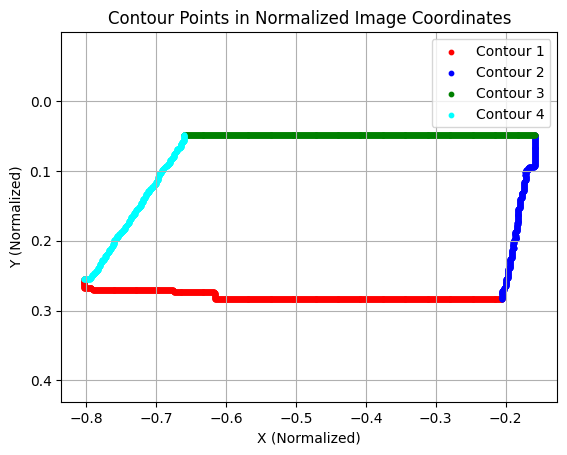

In [29]:
# Segmentation Contour Processing --------------------------
good_weight = 1.0  # Default weight for good edges

# Top-level choice: all edges good (overrides everything else)
if all_edges_good:
    good_edges = [1, 1, 1, 1]
    noisy_edges = []

else: # add noises to the edges and set weights accordingly
    if CONTOUR_NOISE:
        cntr_mode = biased_mode_choice()
        print("Selected cntr_mode:", cntr_mode)

        if generate_random:
            good_edges = generate_good_edges(mode=cntr_mode)
        else:
            # Read the CSV only once if possible
            good_edges_csv_path = f"obj_FINAL1_evaluation/image_{image_num}/good_edges.csv"
            good_edges_df = pd.read_csv(good_edges_csv_path)
            row = good_edges_df[good_edges_df["mask_number"] == mask_number]
            if row.empty:
                raise ValueError(f"No entry for mask_number {mask_number} in {good_edges_csv_path}")
            good_edges = row.iloc[0][["edge 0", "edge 1", "edge 2", "edge 3"]].astype(int).tolist()

        # Check if good_edges has exactly two adjacent 1s
        for i in range(4):
            if good_edges[i] == 1 and good_edges[(i + 1) % 4] == 1 and sum(good_edges) == 2:
                good_weight = 0.9
                break  # No need to check further

        noisy_edges = get_noisy_edges(good_edges)
        cntr_line_weights = get_edge_weights(good_edges, good_weight=good_weight)

    else:
        # If no noise and not using random, just take good edges from CSV
        good_edges_csv_path = f"obj_FINAL1_evaluation/image_{image_num}/good_edges.csv"
        good_edges_df = pd.read_csv(good_edges_csv_path)
        row = good_edges_df[good_edges_df["mask_number"] == mask_number]
        if row.empty:
            raise ValueError(f"No entry for mask_number {mask_number} in {good_edges_csv_path}")
        good_edges = row.iloc[0][["edge 0", "edge 1", "edge 2", "edge 3"]].astype(int).tolist()

        # Check if good_edges has exactly two adjacent 1s
        for i in range(4):
            if good_edges[i] == 1 and good_edges[(i + 1) % 4] == 1 and sum(good_edges) == 2:
                good_weight = 0.9
                break  # No need to check further

        noisy_edges = get_noisy_edges(good_edges)

print(">>>          good_edges:", good_edges)
print(">>>        noisy_edges:", noisy_edges)
print(">>>   cntr_line_weights:", cntr_line_weights)
manual_randomization = False
shift_limit = 22
angle_limit = 0.2
shift = np.random.uniform(-shift_limit, shift_limit)
angle = np.random.uniform(-angle_limit, angle_limit)
shift = 0 if manual_randomization else shift
angle = 0 if manual_randomization else angle
print("Randomizer Shift: ", shift, "Randomizer Angle: ", angle)


segment = np.load("obj_FINAL1_data/YOLO_segment.npy")
segment = clean_segment_mask(segment)  # Clean the segment mask to keep only the largest contour if more than one found
segment_pts_2D = np.column_stack(np.where(segment > 0)) # This is the x_i
np.save("obj_FINAL1_data/segment_pts_2D.npy", segment_pts_2D)
print("Segmentation points shape: ", segment_pts_2D.shape)
segment_uint8 = segment.astype(np.uint8)
grey_segment = cv2.cvtColor(segment_uint8, cv2.COLOR_BGR2GRAY) if len(segment_uint8.shape) == 3 else segment_uint8
# dilate grey segment to fill gaps
#grey_segment = cv2.dilate(grey_segment, np.ones((3, 3), np.uint8), iterations=1)
# Find contours in the segmentation mask
contours_orig, _ = cv2.findContours(grey_segment, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# set contours_orig as the largest contour found
contour_img = img.copy()
cv2.drawContours(contour_img, contours_orig, -1, (255, 0, 0), 3)
print("Shape of contours_orig: ", np.array(contours_orig).shape)

# Algorithm to remove the extra points that are too close to each other -------------
# 1) Get your approx polygon (shape: (N,1,2))
vertex_pts = uf.ApproxPolygon(contours_orig[0], epsilon=0.3)
# 2) Flatten to (N,2)
pts = vertex_pts.reshape(-1, 2).astype(float)
# 3) Remove extras until only 4 corners remain
while pts.shape[0] > 4:
    # 3a) centroid of current vertices
    centroid = pts.mean(axis=0)
    # 3b) find the closest pair
    n = pts.shape[0]
    min_dist = np.inf
    pair = (0,1)
    for i in range(n):
        for j in range(i+1, n):
            d = np.linalg.norm(pts[i] - pts[j])
            if d < min_dist:
                min_dist = d
                pair = (i, j)
    i, j = pair
    # 3c) remove the one of the pair that is closer to the centroid
    if np.linalg.norm(pts[i] - centroid) < np.linalg.norm(pts[j] - centroid):
        remove_idx = i
    else:
        remove_idx = j
    pts = np.delete(pts, remove_idx, axis=0)
# 4) pts now has exactly 4 corner points
vertex_pts = pts
# -------------------------------------------------------
print("Number of vertices after removing extras: ", len(vertex_pts))
print("Vertex points shape: ", vertex_pts.shape)
print("Vertex points: ", vertex_pts)


contour = np.array(contours_orig).reshape(-1, 2)
corner_points = vertex_pts.reshape(-1, 2)

# Extracing contour points between each pair of corner points -------------------
contour_points = contour.tolist()  
corner_indices = [contour_points.index(c.tolist()) for c in corner_points] # list of corner indices
lines = []
for line_num in range(4):
    corner1 = line_num
    corner2 = (line_num + 1) % 4 # cyclic pairwise selection of adjacent corners
    #print("Corner1: ", corner1, "Corner2: ", corner2)
    # Finding the indices of the corners in the contour
    if corner1 < corner2: # if no wraparound then slice directly
        i1, i2 = corner_indices[corner1:corner2 + 1]
    else: # if wraparound then concatenate the slices
        i1, i2 = np.concatenate((corner_indices[corner1:], corner_indices[:corner2 + 1]))
    #print("i1: ", i1, "i2: ", i2)
    # Extracting the segments from the contour points
    if i1 < i2: # if no wraparound then slice directly
        line = contour_points[i1:i2 + 1]
    else: # if wraparound then concatenate the slices
        line = contour_points[i1:] + contour_points[:i2 + 1]
    lines.append(line) # add the segment 
# Draw the lines on the image for verification
for line in lines:
    for i in range(len(line) - 1):
        cv2.line(contour_img, tuple(line[i]), tuple(line[i + 1]), (0, 255, 0), 2)


# ------------------------------------------------------------------
dilation_kernel_size = 1
image_copy = img.copy()
contour_points = []
for i in range(4):
    img = np.zeros_like(image_copy)
    for x,y in lines[i]:
        img[y, x] = 255
    kernel = np.ones((dilation_kernel_size, dilation_kernel_size), np.uint8)
    dilated_img = cv2.dilate(img, kernel, iterations=1)
    dilated_line = np.column_stack(np.where(dilated_img > 0))
    dilated_line = dilated_line[:, [1, 0]]
    np.save(f"obj_FINAL1_data/contour_line_{i+1}_pts.npy", dilated_line[:,:2])
    #print(f"Line {i+1} shape: ", dilated_line[:,:2].shape)
    contour_points.append(dilated_line[:,:2])

print("Contour points shape for each line: ", [pts.shape for pts in contour_points])


contour_points = reorder_edges_to_brtl(contour_points)

contour_points = randomize_contour_lines2(
    contour_points,
    edge_indices=noisy_edges, 
    noise_type='poly',
    noise_level=15.0,
    poly_degree=4,
    shift=shift,
    angle=angle
) if CONTOUR_NOISE else contour_points
print("Contour points shape for each line after randomization: ", [pts.shape for pts in contour_points])

img_copy = img.copy()
# Draw each contour line in different color
colors = ['red', 'blue', 'green', 'cyan'] 
for i, contour_pts in enumerate(contour_points):
    color = (0, 0, 255) if i == 0 else (255, 0, 0) if i == 1 else (0, 255, 0) if i == 2 else (255, 255, 0)
    for i, point in enumerate(contour_pts):
        x, y = point
        center = (int(x), int(y))
        cv2.circle(image_copy, center, 1, color, -1)



# Transform contour points to normalized image coordinates -------------------------
cntr_pts_norm_list = [] # list to store the normalized contour points
for i, cntr_pts in enumerate(contour_points):
    cntr_pts_norm = ptsToNormImageCoords(cntr_pts, adjust_px_offset=False)
    #cntr_pts_norm[:, 1] *= -1  # Flip y-coordinates
    print("Contour points in normalized image coordinates shape: ", cntr_pts_norm.shape)
    #np.save(f"obj_FINAL1_data/contour_line_{i+1}_pts_normed.npy", cntr_pts_norm)
    cntr_pts_norm_list.append(cntr_pts_norm)

for i, cntr_pts_norm in enumerate(cntr_pts_norm_list):
    np.save(f"obj_FINAL1_data/contour_line_{i+1}_pts_normed.npy", cntr_pts_norm)


colors = ['red', 'blue', 'green', 'cyan']  # Define colors for each contour
# Plot each contour in a different color (flipped by negating the y-coordinates)
for i, cntr_pts_norm in enumerate(cntr_pts_norm_list):
    plt.scatter(cntr_pts_norm[:, 0], cntr_pts_norm[:, 1], color=colors[i], label=f'Contour {i+1}', s=10)
# Add labels and legend
plt.title("Contour Points in Normalized Image Coordinates")
plt.xlabel("X (Normalized)")
plt.ylabel("Y (Normalized)")
plt.gca().invert_yaxis()
plt.legend()
plt.axis("equal")
plt.grid(True)
# save the plot
plt.savefig(save_dir + "/contour_line_pts_grouped.png", dpi=400, bbox_inches='tight')


plane model from RANSAC:  [   0.025767    -0.71952    -0.69399     0.43669]
N_X_3d:  58077
Centroid actual:  [   -0.24201    0.083503     0.53368]
Final contour_sets shapes (B-R-T-L): [(1365, 2), (561, 2), (1101, 2), (564, 2)]
segmentation point cloud width_extent: 0.5537901959531226
segmentation point cloud height_extent: 0.196390060058398
is_vertical flag: False


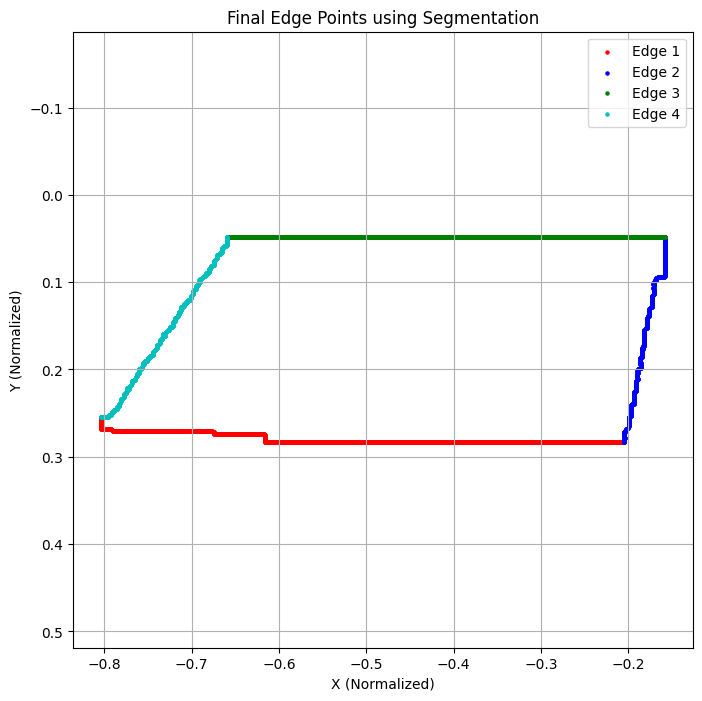

In [30]:
# Data loading and initialization --------------------------------
pts3d = np.load("obj_FINAL1_data/segment_pts_3D.npy")  # (N, 3)
pts3d_color = np.load("obj_FINAL1_data/segment_pts_3D_color.npy")  # (N, 3)

# using RANSAC
pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pts3d))
plane_model, inliers = pcd.segment_plane(distance_threshold=0.0025,
                                         ransac_n=3,
                                         num_iterations=1000)
pts3d = pts3d[inliers]
pts3d_color = pts3d_color[inliers]
init_plane = -plane_model
print("plane model from RANSAC: ", init_plane)


X_3d = np.hstack([pts3d, np.ones((pts3d.shape[0], 1))])  # shape (N,4)
N_X_3d = X_3d.shape[0]
print("N_X_3d: ", N_X_3d)

centr_actual = np.mean(pts3d, axis=0)
print("Centroid actual: ", centr_actual)

contour_sets = [
    np.load(f"obj_FINAL1_data/contour_line_{i+1}_pts_normed.npy")
    for i in range(4)
]
print("Final contour_sets shapes (B-R-T-L):", [c.shape for c in contour_sets])

is_vertical, init_wid, init_len = is_box_vertical3D(contour_sets, pts3d)
print("is_vertical flag:", is_vertical)
records.append({
    "is_vertical": "True" if is_vertical else "False",
})

# ─── Verify final contour_sets in different colors ───
colors = ['r','b','g','c']           # one color per edge index 0–3
labels = ['Edge 1','Edge 2','Edge 3','Edge 4']
plt.figure(figsize=(8, 8))
for i, pts in enumerate(contour_sets):
    if pts.size == 0:
        continue
    plt.scatter(
        pts[:, 0], pts[:, 1],
        c=colors[i],
        label=labels[i],
        s=5
    )
plt.title("Final Edge Points using Segmentation")
plt.xlabel("X (Normalized)")
plt.ylabel("Y (Normalized)")
plt.gca().invert_yaxis()
plt.axis("equal")
plt.grid(True)
plt.legend()
# save the plot
plt.savefig(save_dir + "/final_contour_line_pts_sets.png", dpi=400, bbox_inches='tight')

In [31]:
# Optimization -------------------------------------------------------------------------------------


# Weights and scalars -----------------------------------
final_weights /= np.sum(final_weights)
records.append({
    "final_weights": final_weights.tolist()
})

cntr_line_weights = np.array(cntr_line_weights, dtype=float)
cntr_line_weights /= np.sum(cntr_line_weights)
records.append({
    "cntr_line_weights": cntr_line_weights.tolist()
})

error_scaler = 1e5
centroid_eps = 1e-8
centroid_alpha = 5

log_path = save_dir + "/optimizer_log.csv"

# Global Objective Function ---------------------------------------------------
def monitored_objective(num):
    counter = {'it': 0}

    # 0) Initialize CSV with header
    header = (
        ["iter", "E_line", "E_pose", "E_plane", "E_centroids", "E_total"]
        + [f"x{i}" for i in range(23)]
    )
    with open(log_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(header)

    def fun(x):
        counter['it'] += 1    
        """
        x = [
        a1,b1,c1, …, a4,b4,c4,      # 12 line params
        qw,qx,qy,qz,               # quaternion
        tx,ty,tz,                  # translation in camera frame
        nx,ny,nz,dp                # top-plane ep = [n, -d]
        ]
        """
        # unpack
        abc = np.array(x[0:12]).reshape(4,3)
        qw,qx,qy,qz = x[12:16]
        t_cam = np.array(x[16:19])
        C_ep   = np.array(x[19:23])
        if known_dims:
            box_dims = box_dimensions
        else:
            box_dims= np.array(x[23:25])  # [length, width] in m


        # --- 1) 2D line‐fit term ------------------------------------------------------
        E_line = 0.0
        for i,(a,b,c) in enumerate(abc):
            pts = contour_sets[i]
            N_i= pts.shape[0]
            E_line += cntr_line_weights[i] * np.sum((a*pts[:,0] + b*(-pts[:,1]) - c)**2) / N_i # y flipped

        # --- 2) top‐plane‐fit term  -------------------------------------------
        # force unit‐normal for ep
        C_ep[:3] /= np.linalg.norm(C_ep[:3]) # normed
        r = X_3d.dot(C_ep)                   # algebraic distances
        E_plane = np.mean(r**2)

        # --- 3) observed 3D corners via 3‐plane intersection -------------------------------------------
        # planes e_i = [a,b,-c,0],  ep = [n_x,n_y,n_z,-d]
        ep = C_ep
        corners_obs = []
        for i in range(4):
            # 1) unpack the raw abc planes
            nx1_o, ny1_o, d1_o = abc[i]
            nx2_o, ny2_o, d2_o = abc[(i+1) % 4]
            # 2) build the flipped‐y, normalized normals
            n1 = np.array([ nx1_o, -ny1_o, -d1_o ], dtype=float)
            n1 /= np.linalg.norm(n1)
            n2 = np.array([ nx2_o, -ny2_o, -d2_o ], dtype=float)
            n2 /= np.linalg.norm(n2)
            # 3) the “end-effector” plane
            n3 = ep[:3]            # normal
            d3 = -ep[3]            # RHS: n3·P = d3
            # 4) intersection via P = (d1 n2×n3 + d2 n3×n1 + d3 n1×n2) / (n1·(n2×n3))
            #    but here d1=d2=0 so it collapses to P = d3 * (n1×n2) / [n3·(n1×n2)]
            cross12 = np.cross(n1, n2)
            denom   = np.dot(n3, cross12)
            if abs(denom) < 1e-6:
                # planes are almost parallel → fallback or nan
                P_i = np.array([np.nan, np.nan, np.nan])
            else:
                P_i = (d3 * cross12) / denom
            #P_i = (d3 * cross12) / denom
            corners_obs.append(P_i)
        corners_obs = np.vstack(corners_obs)  # (4,3)
        #corners_obs[:,0] *= -1.0  # FLIP x coordinate to match camera frame

        dim_i1 = box_dims[1] / 2 # half width
        dim_i2 = box_dims[0] / 2 # half length
        dim_i1_list = [dim_i1, -dim_i1, -dim_i1, dim_i1]
        dim_i2_list = [-dim_i2, -dim_i2, dim_i2, dim_i2] 
        # Box Frame Corner Points
        B_corners = np.stack([
            [dim_i1_list[i], dim_i2_list[i], 0.0]
            for i in range(4)
        ], axis=0)  # shape (4,3)
        B_corners = np.roll(B_corners, 2, axis=0) 

        # --- 4) model 3D corners via full quaternion + translation ---
        # normalize quaternion to ensure |q|=1
        q = np.array([qw,qx,qy,qz], dtype=float)
        q /= np.linalg.norm(q)
        # rotation matrix from q
        R = R_from_quat(q)
        # B_corners: your local box‐top corners in box‐frame (4×3)
        corners_model = (R @ B_corners.T).T + t_cam  # (4,3)
        #corners_model[:,0] *= -1.0  # FLIP x coordinate to match camera frame

        # --- 5) pose term = mean squared corner‐to‐corner distance ---
        diffs = corners_obs - corners_model         # (4,3)
        E_pose_vec = np.einsum('ij,ij->i', diffs, diffs)
        #E_pose = np.sum(pose_weights * E_pose_vec)  # weighted mean squared distance
        E_pose = np.mean(E_pose_vec)                # unweighted mean squared distance

        if CONTOUR_NOISE:
            centr_obs = np.mean(corners_obs, axis=0)
            E_centroids = ((np.sum(centr_actual - centr_obs)**2) + centroid_eps) ** centroid_alpha
        else:
            E_centroids = 0.0

        E_total = (
            final_weights[0]*error_scaler*E_line   +
            final_weights[1]*error_scaler*E_pose   +
            final_weights[2]*error_scaler*E_plane
        )

        # --- append row to CSV ---------------------------
        if log:
            #logging_time_start = time.perf_counter()
            if counter["it"] % num == 0:
                row = [
                    counter["it"], E_line, E_pose, E_plane, E_centroids, E_total/error_scaler
                ] + x.tolist()
                with open(log_path, "a", newline="") as f:
                    writer = csv.writer(f)
                    writer.writerow(row)
            #logging_time_end = time.perf_counter()
            #logging_time = logging_time_end - logging_time_start

        return E_total
    
    return fun
# ---------------------------------------------------------------------------------------

# Constraints 
def quat_unit(x):
    qw,qx,qy,qz = x[12:16]
    return qw*qw + qx*qx + qy*qy + qz*qz - 1

cons = (
    # 4 line‐normal unit constraints
    *[{'type':'eq', 'fun': lambda x,i=i: x[3*i]**2 + x[3*i+1]**2 - 1}
      for i in range(4)],
    # quaternion unit‐norm
    {'type':'eq', 'fun': quat_unit},
    # ep plane unit‐norm
    {'type':'eq', 'fun': lambda x: x[19]**2 + x[20]**2 + x[21]**2 - 1},
)

# Bounds
quat_bounds = [
    (None, None),
    (None, None),
    (None, None),
    (None, None),
]
# trans_bounds = [
#     (None, None),
#     (None, None),
#     (None, None)
# ]
trans_bounds = [
    (-0.75, 0.75),  # tx
    (-0.75, 0.75),  # ty
    (0.0, 3.0),  # tz
]
lines_bounds = [
    (-1.0001, 1.0001),  # a_i
    (-1.0001, 1.0001),  # b_i
    (None, None),   # c_i
] * 4
# lines_bounds = [
#     (None, None),  # a_i
#     (None, None),  # b_i
#     (None, None),   # c_i
# ] * 4
plane_bounds = [
    (-1.0001, 1.0001),  # nx
    (-1.0001, 1.0001),  # ny
    (-1.0001, 1.0001),  # nz
    (0.0, 10.0)   # -d
]
# plane_bounds = [
#     (None, None),  # nx
#     (None, None),  # ny
#     (None, None),  # nz
#     (0, None)   # -d
# ]
box_dim_bounds = [
    (0.05, 1.5),  # length
    (0.05, 1.5)   # width
]

if known_dims:
    bounds = lines_bounds + quat_bounds + trans_bounds + plane_bounds 
else:
    bounds = lines_bounds + quat_bounds + trans_bounds + plane_bounds + box_dim_bounds
# -----------------------------------------------------------------------------------------

# Initial guess 

# 1) lines at 0°, 90°, 180°, 270° with offset = 1, forming a square with existing intersections
phis = np.arange(4) * (np.pi/2)
a = np.cos(phis)           # [1, 0, –1,  0]
b = np.sin(phis)           # [0, 1,  0, –1]
c = np.ones(4)             # so x=1, y=1, x=-1, y=-1
# pack into [a1,b1,c1, a2,b2,c2, a3,b3,c3, a4,b4,c4]
init_lines = np.column_stack((a, b, c)).ravel()
print("init_lines: ", init_lines)
# 3) initial guess for the plane normal and distance
ep0 = np.array([0, 0, -1, np.mean(pts3d[:,2])])
#ep0 = init_plane
# add slight changes to the plane parameters
#ep0 += np.array([0.05, 0.05, 0.0, 0.0])
print("ep0: ", ep0)
# 2) initial guess for the pose params
cam_down = np.array([0.0, 0.0, -1.0])
#cam = np.array([0.0, 0.0, -1.0])
plane_norm = ep0[:3]
plane_norm = plane_norm / np.linalg.norm(plane_norm)
init_quat = quat_from_two_vectors(cam_down, plane_norm)
#init_quat = quat_from_two_vectors(cam, plane_norm)
print("init_quat: ", init_quat)
init_trans = np.mean(pts3d, axis=0)
print("init_trans: ", init_trans)
# initial guess for the box dimensions
init_box_dims = np.array([init_len, init_wid])  # [length, width] in m
print("initial dimensions: ", init_box_dims)

# 4) pack all params into a single vector
if known_dims:
    init_params = np.hstack([init_lines, init_quat, init_trans, ep0])
else:
    init_params = np.hstack([init_lines, init_quat, init_trans, ep0, init_box_dims])
print("init_params = ", init_params)
records.append({
    "init_params": init_params.tolist()
})


# Performing the optimization ---------------------------------------------
num = 25
obj = monitored_objective(num)
# callback
losses = []
def callback(xk):
    loss = obj(xk)
    losses.append(loss)
    #print(f"Loss: {loss:.4e}")

start_time = time.perf_counter()
res = minimize(
    obj,
    init_params,
    method='SLSQP',
    bounds=bounds,
    constraints=cons,
    callback=callback,
    options={'disp':True,
             'maxiter':500,
             'ftol':1e-10
             }
)
end_time   = time.perf_counter()

# Recovering the optimized parameters ---------------------
if known_dims:
    (a1,b1,c1,
    a2,b2,c2,
    a3,b3,c3,
    a4,b4,c4,
    qw,qx,qy,qz,
    tx,ty,tz,
    nxp,nyp,nzp, dp) = res.x
else:
    (a1,b1,c1,
    a2,b2,c2,
    a3,b3,c3,
    a4,b4,c4,
    qw,qx,qy,qz,
    tx,ty,tz,
    nxp,nyp,nzp, dp,
    length, width) = res.x

# 1) Lines
optimal_lines = np.array([
    [a1, b1, c1],
    [a2, b2, c2],
    [a3, b3, c3],
    [a4, b4, c4]
])

# 2) Top‐plane
C_ep_opt = np.array([nxp, nyp, nzp, dp], dtype=float)
# normalize so ||n||=1
C_ep_opt[:3] /= np.linalg.norm(C_ep_opt[:3])
n = C_ep_opt[:3]
d = C_ep_opt[3]

# 3) Camera→Box rotation & translation
q_opt = np.array([qw, qx, qy, qz], dtype=float)
q_opt /= np.linalg.norm(q_opt)            # ensure unit‐quat             

R_opt = R_from_quat(q_opt)                # 3×3 rotation
t_opt = np.array([tx, ty, tz]).reshape(3,1)

# 4) (Optional) plane basis for visualization or further use
#    plane origin (foot of perp from camera)
p0    = -d * n
#    pick an arbitrary in‐plane axis
a_vec = np.array([1.0, 0.0, 0.0])
if abs(a_vec.dot(n)) > 0.9:
    a_vec = np.array([0.0, 1.0, 0.0])
u     = np.cross(n, a_vec);  u /= np.linalg.norm(u)
v     = np.cross(n, u)
R_plane = np.column_stack((u, v, n))

if known_dims:
    box_dim_opt = box_dimensions
else:
    box_dim_opt = np.array([length, width], dtype=float)  # [length, width] in m
dim_i1 = box_dim_opt[1] / 2 # half width
dim_i2 = box_dim_opt[0] / 2 # half length
dim_i1_list = [dim_i1, -dim_i1, -dim_i1, dim_i1]
dim_i2_list = [-dim_i2, -dim_i2, dim_i2, dim_i2] 
# Box Frame Corner Points
B_corners = np.stack([
    [dim_i1_list[i], dim_i2_list[i], 0.0]
    for i in range(4)
], axis=0)  # shape (4,3)
B_corners = np.roll(B_corners, 2, axis=0) 
corners_model_opt = (R_opt @ B_corners.T).T + t_opt.flatten()

# 5) Print everything
time_duration = end_time - start_time
final_loss = res.fun
records.append({
    "final_loss": float(final_loss),
    "time_duration": float(time_duration),
    "optimized_parameters": (res.x).tolist()
})

print("Time duration:", time_duration)
print("Optimized line params:\n", optimal_lines)
print(" ")
print("Optimized plane ep (normalized):", C_ep_opt)
print(" Plane normal n:", n)
print(" Plane distance d:", d)
print(" Plane origin p0:", p0)
print(" In‐plane basis u, v:\n", u, "\n", v)
print(" ")
print("Optimized quaternion [qw,qx,qy,qz]:", q_opt)
print("Quaternion norm:", np.linalg.norm(q_opt))
print("Rotation matrix R_opt:\n", R_opt)
print(" ")
print("Optimized translation t_opt (camera→box):", t_opt.flatten())
print("")
print("Optimized model corners:\n", corners_model_opt)
print("")
print("Optimized box dimensions [length, width]:", box_dim_opt)


init_lines:  [          1           0           1  6.1232e-17           1           1          -1  1.2246e-16           1  -1.837e-16          -1           1]
ep0:  [          0           0          -1     0.53368]
init_quat:  [          1           0           0           0]
init_trans:  [   -0.24201    0.083503     0.53368]
initial dimensions:  [    0.55379     0.19639]
init_params =  [          1           0           1  6.1232e-17           1           1          -1  1.2246e-16           1  -1.837e-16          -1           1           1           0           0           0    -0.24201    0.083503     0.53368           0           0          -1     0.53368]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.27211920543442747
            Iterations: 110
            Function evaluations: 2717
            Gradient evaluations: 110
Time duration: 0.7716324430002715
Optimized line params:
 [[   0.021739     0.99976    -0.29027]
 [   -0.98188     0.

 > > > corners_model:  [[  -0.096159     0.13665      0.4783]
 [  -0.092779    0.031068     0.59036]
 [   -0.38871    0.026278     0.59477]
 [   -0.39209     0.13186     0.48271]]
 > > > corners_model.shape:  (4, 3)
R_est:
 [[   0.021949     0.99976  -0.0015509]
 [   -0.68561    0.016181     0.72779]
 [    0.72763   -0.014911      0.6858]]
t_est:
 [   -0.24243    0.081465     0.53653]
Saved camera view and top view snapshots.


Columns in the CSV file: ['iter', 'E_line', 'E_pose', 'E_plane', 'E_centroids', 'E_total', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22']


IndexError: single positional indexer is out-of-bounds

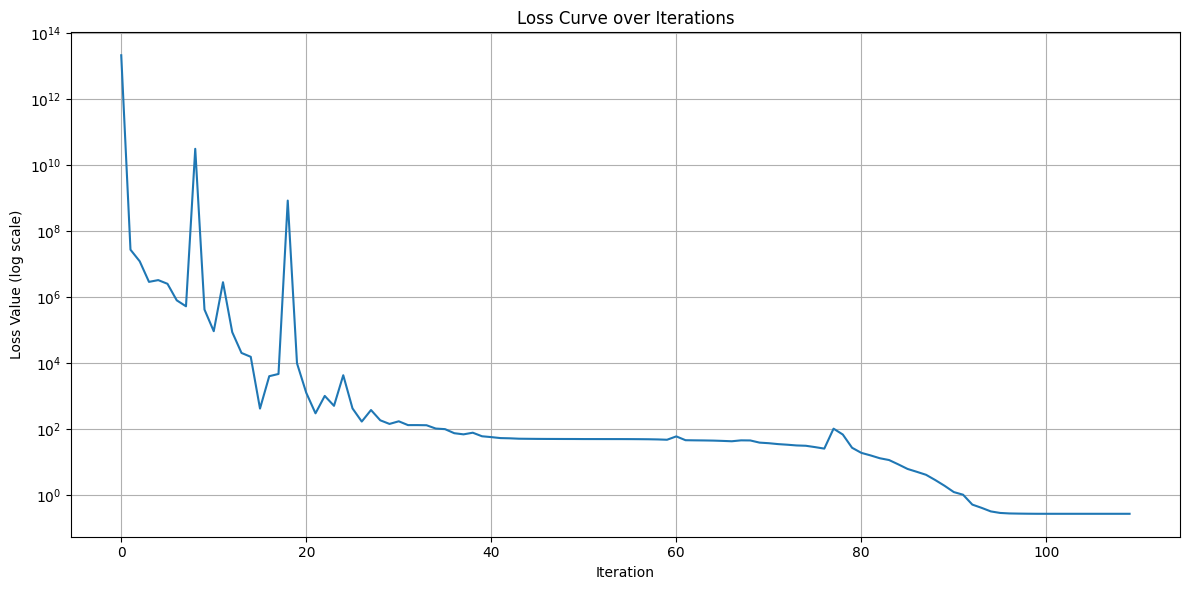

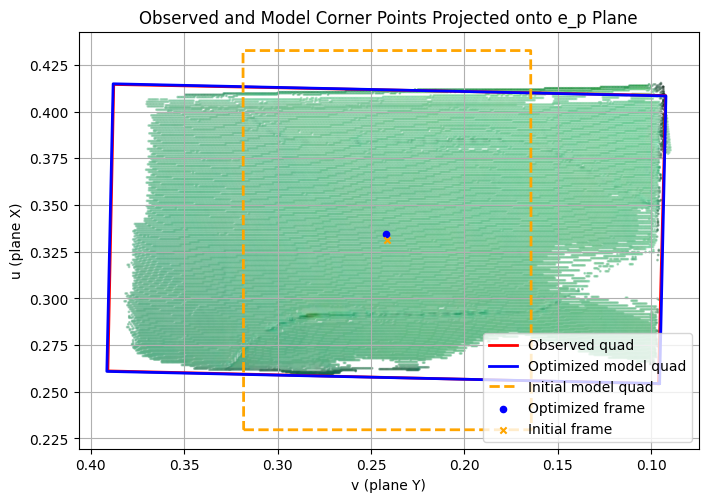

In [32]:
# Post-processing and saving results ----------------------------------------------------

# -------------------------- add to csv -----------------------
# the exact column ordering you want
columns = [
    "MaskNum",
    "Pose_Cam_X","Pose_Cam_Y","Pose_Cam_Z",
    "Pose_Cam_Ori_X","Pose_Cam_Ori_Y","Pose_Cam_Ori_Z","Pose_Cam_Ori_W",
    "BBox_Cam_Extent_X","BBox_Cam_Extent_Y","BBox_Cam_Extent_Z",
    "BBox_Cam_Center_X","BBox_Cam_Center_Y","BBox_Cam_Center_Z",
    "BBox_Cam_R00","BBox_Cam_R01","BBox_Cam_R02",
    "BBox_Cam_R10","BBox_Cam_R11","BBox_Cam_R12",
    "BBox_Cam_R20","BBox_Cam_R21","BBox_Cam_R22"
]

# 1) If the file doesn’t exist, write only the header
if not os.path.exists(csv_path):
    pd.DataFrame(columns=columns).to_csv(csv_path, index=False)

pts = np.asarray(corners_model_opt)           # shape (4,3)
# compute the plane normal
v1 = pts[1] - pts[0]
v2 = pts[2] - pts[0]
normal = np.cross(v1, v2)
normal /= np.linalg.norm(normal)
# give it a tiny thickness (e.g. 1 cm)
epsilon = 0.01
model_pts_3d = np.vstack([
    pts,
    pts + normal * epsilon
])
# 2) build the OBB from your model corners
obb = o3d.geometry.OrientedBoundingBox.create_from_points(
    o3d.utility.Vector3dVector(model_pts_3d)
)
center = obb.center       # [x,y,z]
extent = obb.extent       # [ex,ey,ez]
R = obb.R                 # 3×3 rotation matrix

# 3) pack everything into a new row (quaternion as [x,y,z,w])
if is_vertical:
    # Convert [qw, qx, qy, qz] to scipy's [x, y, z, w] format
    rot_opt = Rotation.from_quat([q_opt[1], q_opt[2], q_opt[3], q_opt[0]])  # [x, y, z, w]
    # Define a +90° rotation around the local Z-axis
    rot_z_90 = Rotation.from_euler('z', 90, degrees=True)
    # Post-multiply to rotate around the local Z-axis of the box
    rot_opt_rotated = rot_opt * rot_z_90
    # Convert back to [qw, qx, qy, qz]
    q_new = rot_opt_rotated.as_quat()  # [x, y, z, w]
    q_opt_rot = np.array([q_new[3], q_new[0], q_new[1], q_new[2]], dtype=float)  # [qw, qx, qy, qz]
    q_opt_rot /= np.linalg.norm(q_opt)  # Normalize to ensure it's a unit quaternion

qw, qx, qy, qz = q_opt_rot if is_vertical else q_opt
tx, ty, tz = t_opt.flatten()
row = {
    "MaskNum":           mask_number,
    "Pose_Cam_X":        tx,
    "Pose_Cam_Y":        ty,
    "Pose_Cam_Z":        tz,
    "Pose_Cam_Ori_X":    qx,
    "Pose_Cam_Ori_Y":    qy,
    "Pose_Cam_Ori_Z":    qz,
    "Pose_Cam_Ori_W":    qw,
    "BBox_Cam_Extent_X": extent[0],
    "BBox_Cam_Extent_Y": extent[1],
    "BBox_Cam_Extent_Z": extent[2],
    "BBox_Cam_Center_X": center[0],
    "BBox_Cam_Center_Y": center[1],
    "BBox_Cam_Center_Z": center[2],
    "BBox_Cam_R00":      R[0,0],
    "BBox_Cam_R01":      R[0,1],
    "BBox_Cam_R02":      R[0,2],
    "BBox_Cam_R10":      R[1,0],
    "BBox_Cam_R11":      R[1,1],
    "BBox_Cam_R12":      R[1,2],
    "BBox_Cam_R20":      R[2,0],
    "BBox_Cam_R21":      R[2,1],
    "BBox_Cam_R22":      R[2,2],
}

# 4) append it
new_row_df = pd.DataFrame([row], columns=columns)
new_row_df.to_csv(csv_path, mode='a', header=False, index=False)
# -------------------------------------------------------------


show7 = False
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(losses, label='Loss')
ax.set_title('Loss Curve over Iterations')
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss Value (log scale)')
ax.set_yscale('log')
ax.grid(True)
plt.tight_layout()
fig.savefig(save_dir + "/loss_curve.png", dpi=400, bbox_inches='tight')
# ───────────────────────────────────────────────────────

# --- 1) Configuration: parameterizable colors & lengths ---
cloud_cmap         = None               # uses pts3d_color directly
obs_quad_color     = 'red'
opt_quad_color     = 'blue'
init_quad_color    = 'orange'
axis_opt_color     = 'blue'
axis_init_color    = 'orange'
origin_opt_color   = axis_opt_color
origin_init_color  = axis_init_color
axis_len           = 0.05                # length of axes arrows in plane units
origin_size        = 20                # scatter size for origins
line_width         = 2

# --- 2) Compute observed & optimized & initial UVs (as before) ---
# assume ep, p0, u, v, pts3d, pts3d_color, B_corners, q_opt, t_opt, init_quat, init_trans are in scope
#pts3d_color = np.load("obj_FINAL1_data/segment_pts_3D_color.npy")  # (N, 3)
# 1) observed corners via 3-plane intersection
abc = optimal_lines
ep  = C_ep_opt.copy()
# no need to renormalize ep[:3] – already unit
corners_obs = []
for i in range(4):
    a,b,c   = abc[i]
    a2,b2,c2= abc[(i+1)%4]
    # flip y same as objective
    e1 = np.array([ a, -b, -c, 0.0])
    e2 = np.array([a2, -b2, -c2, 0.0])
    A  = np.vstack((e1[:3], e2[:3], ep[:3]))
    #bv = np.array([-e1[3], -e2[3], -ep[3]])
    bv = np.array([0.0, 0.0, -ep[3]])
    P  = np.linalg.solve(A, bv)
    corners_obs.append(P)
corners_obs = np.array(corners_obs)  # (4,3)

# 2) model corners via quaternion+translation
def R_from_quat(q):
    w,x,y,z = q
    return np.array([
    [1-2*(y*y+z*z), 2*(x*y - z*w), 2*(x*z + y*w)],
    [2*(x*y + z*w), 1-2*(x*x+z*z), 2*(y*z - x*w)],
    [2*(x*z - y*w), 2*(y*z + x*w), 1-2*(x*x+y*y)]
    ])
R_opt = R_from_quat(q_opt)
corners_model = (R_opt @ B_corners.T).T + t_opt.flatten()
print(" > > > corners_model: ", corners_model)  # (4,3)
print(" > > > corners_model.shape: ", corners_model.shape)  # (4,3)

# Helper: projection to plane coords
def proj(P):
    d = P - p0
    return np.array([u.dot(d), v.dot(d)])

# observed corners
corners_obs = []
for i in range(4):
    a,b,c    = abc[i]
    a2,b2,c2 = abc[(i+1)%4]
    e1 = np.array([ a, -b, -c, 0])
    e2 = np.array([a2,-b2,-c2,0])
    A  = np.vstack((e1[:3], e2[:3], ep[:3]))
    bv = np.array([-e1[3], -e2[3], -ep[3]])
    P  = np.linalg.solve(A, bv)
    corners_obs.append(P)
corners_obs = np.array(corners_obs)         # (4,3)

# optimized model corners
R_opt = R_from_quat(q_opt)
corners_model_opt = (R_opt @ B_corners.T).T + t_opt.flatten()

# initial model corners
R_init = R_from_quat(init_quat)
corners_model_init = (R_init @ B_corners.T).T + init_trans

# project all into UV
obs_uv        = np.array([proj(P) for P in corners_obs])
mod_uv_opt    = np.array([proj(Q) for Q in corners_model_opt])
mod_uv_init   = np.array([proj(Q) for Q in corners_model_init])
pts_uv        = np.array([proj(P) for P in pts3d])

# origins for axes: projection of translation onto plane
origin_uv_opt  = proj(t_opt.flatten())
origin_uv_init = proj(init_trans)

# axis directions in plane coords
#x_dir_uv_opt = np.array([u.dot(R_opt[:,0]), u.dot(R_opt[:,0])]) * 0  # placeholder
# Corrected: use u and v components
x_dir_uv_opt = np.array([u.dot(R_opt[:,0]), v.dot(R_opt[:,0])])
y_dir_uv_opt = np.array([u.dot(R_opt[:,1]), v.dot(R_opt[:,1])])

x_dir_uv_init = np.array([u.dot(R_init[:,0]), v.dot(R_init[:,0])])
y_dir_uv_init = np.array([u.dot(R_init[:,1]), v.dot(R_init[:,1])])

# axis endpoints
x_end_uv_opt  = origin_uv_opt  + axis_len * x_dir_uv_opt
y_end_uv_opt  = origin_uv_opt  + axis_len * y_dir_uv_opt
x_end_uv_init = origin_uv_init + axis_len * x_dir_uv_init
y_end_uv_init = origin_uv_init + axis_len * y_dir_uv_init

# --- 3) Plotting with v on X‐axis and u on Y‐axis ---
fig, ax = plt.subplots(figsize=(8, 8))

# 3a) scatter the point cloud (v = pts_uv[:,1] → x, u = pts_uv[:,0] → y)
ax.scatter(
    pts_uv[:, 1], pts_uv[:, 0],
    c=pts3d_color,
    s=1, alpha=0.5
)

# 3b) draw observed & optimized quads
for uv, color, label in [
    (obs_uv,     obs_quad_color,  'Observed quad'),
    (mod_uv_opt, opt_quad_color,  'Optimized model quad')
]:
    quad = np.vstack([uv, uv[0]])  # (5,2)
    ax.plot(
        quad[:, 1], quad[:, 0],   # swap columns
        '-', color=color,
        linewidth=line_width,
        label=label
    )

# 3c) draw initial‐guess quad
quad_init = np.vstack([mod_uv_init, mod_uv_init[0]])
ax.plot(
    quad_init[:, 1], quad_init[:, 0],  # swap
    '--', color=init_quad_color,
    linewidth=line_width,
    label='Initial model quad'
)

# 3d) draw optimized axes & origin
# origin_uv_opt = [u0, v0]
ax.scatter(
    origin_uv_opt[1], origin_uv_opt[0],  # v, u
    c=origin_opt_color, s=origin_size,
    marker='o', label='Optimized frame'
)

# 3e) draw initial axes & origin
ax.scatter(
    origin_uv_init[1], origin_uv_init[0],  # v, u
    c=origin_init_color, s=origin_size,
    marker='x', label='Initial frame'
)

# 3f) finalize
ax.set_aspect('equal', 'box')
ax.set_xlabel('v (plane Y)')   # swapped
ax.set_ylabel('u (plane X)')   # swapped
#ax.set_ylim(ax.get_ylim()[::-1])  # flip vertical (u) if needed
ax.set_xlim(ax.get_xlim()[::-1])  # flip horizontal (v) if needed
ax.set_title('Observed and Model Corner Points Projected onto e_p Plane')
ax.legend(loc='best')
ax.grid(True)
fig.savefig(save_dir + "/plot_on_ep_plane.png", dpi=400, bbox_inches='tight')
# ───────────────────────────────────────────────────────
# save the plot


pts3d_color = np.load("obj_FINAL1_data/segment_pts_3D_color.npy")  # (N, 3)
fx, fy, cx, cy, w, h = (
    cam_intrinsics[0], cam_intrinsics[1],
    cam_intrinsics[2], cam_intrinsics[3],
    rgb_img.shape[1], rgb_img.shape[0]
)

# single flip: (X stays, Y flips, Z flips)
FLIP = np.diag([1.0, -1.0, -1.0])

def R_from_quat(q):
    w,x,y,z = q
    return np.array([
        [1-2*(y*y+z*z), 2*(x*y - z*w), 2*(x*z + y*w)],
        [2*(x*y + z*w), 1-2*(x*x+z*z), 2*(y*z - x*w)],
        [2*(x*z - y*w), 2*(y*z + x*w), 1-2*(x*x+y*y)]
    ])

opt_params = res.x[:23]
# If not vertical, replace with rotated quaternion
if is_vertical:
    opt_params[12:16] = q_opt_rot

init_params = init_params[:23]

R_est, t_est, cam_frame, box_frame_est, plane_mesh_est, seg_cloud, quad_obs_est, quad_mod_est, axis_spheres_est, obs_spheres_est, mod_spheres_est = visualize_fullpose(
    opt_params,
    B_corners,
    pts3d, pts3d_color,
    fx, fy, cx, cy, w, h,
    frame_size=0.06,
    plane_size=0.25,
    sphere_radius=0.004,
    sphere_offset=0.0,                  # distance beyond arrow tip
    box_frame_color=(0.25, 0.8, 0.8),     # uniform frame color
    cam_frame_color=(0.4, 0.4, 0.4),     # uniform frame color
    plane_color=(0.2, 0.2, 0.35),         # plane color
    obs_corner_color=(1, 0, 0),          # observed corners color
    mod_corner_color=(0, 0, 1)           # model corners color
)
print("R_est:\n", R_est)
print("t_est:\n", t_est)

_, _, _, box_frame_init, plane_mesh_init, _, quad_obs_init, quad_mod_init, axis_spheres_init, obs_spheres_init, mod_spheres_init = visualize_fullpose(
    init_params,
    B_corners,
    pts3d, pts3d_color,
    fx, fy, cx, cy, w, h,
    frame_size=0.04,
    plane_size=0.25,
    sphere_radius=0.0025,
    sphere_offset=0.0,                  # distance beyond arrow tip
    box_frame_color=(0.55, 0.25, 0.25),     # uniform frame color
    cam_frame_color=(0.4, 0.4, 0.4),     # uniform frame color
    plane_color=(0.35, 0.2, 0.2),         # plane color
    obs_corner_color=(0.4, 0.1, 0.1),          # observed corners color
    mod_corner_color=(0.1, 0.1, 0.4)           # model corners color
)

show20 = False
if show20:
    o3d.visualization.draw_geometries([
        cam_frame,
        seg_cloud,

        box_frame_est,
        plane_mesh_est,

        box_frame_init,
        #plane_mesh_init,

        quad_obs_est,
        quad_mod_est,
        #quad_obs_init,
        #quad_mod_init,

        *axis_spheres_est,
        *obs_spheres_est,
        *mod_spheres_est,
        *axis_spheres_init,
        #*obs_spheres_init,
        #*mod_spheres_init

    ], width=1600, height=1000) 

# save it
geoms = [
    cam_frame,
    box_frame_est,
    plane_mesh_est,
    seg_cloud,
    quad_obs_est,
    quad_mod_est,
    *axis_spheres_est,
    *obs_spheres_est,
    *mod_spheres_est,
    box_frame_init,
    #plane_mesh_init,
    #quad_obs_init,
    #quad_mod_init,
    *axis_spheres_init,
    #*obs_spheres_init,
    #*mod_spheres_init
]
scene_num = 1
save_open3d_scene(geoms, save_dir + f"/open3d_scene_{scene_num}")


flip = np.array([[ 1,  0,  0, 0],
                 [ 0, -1,  0, 0],
                 [ 0,  0, -1, 0],
                 [ 0,  0,  0, 1]])

# 3×3 part for rotating frames or boxes
Rflip = flip[:3, :3]

# --- Generate point cloud ---
# construct custom pinhole intrinsic
intrinsic = o3d.camera.PinholeCameraIntrinsic(
    w, h,
    fx, fy, cx, cy
)


save_img_file1 = save_dir + "/visualize_all_3d_top_view.png"
save_img_file2 = save_dir + "/visualize_all_3d_camera_view.png"


T_top = np.load("obj_FINAL1_data/permanent_data/top_view_frame_transform.npy")
# create and place the frame
frame_top = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)
frame_top.transform(T_top)
frame_top.transform(flip)
geoms.append(frame_top)


# --- OFFSCREEN RENDER & COLORED SNAPSHOT ---
vis = o3d.visualization.Visualizer()
vis.create_window(width=1930, height=1930, visible=False)
# dark BG
opt = vis.get_render_option()
opt.background_color = np.array([0.5, 0.5, 0.5])
opt.point_size = 2.0
# 1) add the colored point cloud
vis.add_geometry(pcd)
vis.update_geometry(pcd)
# 2) add all grasp‐pose frames & boxes, but skip the top‐view arrow
for g in geoms:
    if g is frame_top or g is cam_frame:
        continue
    vis.add_geometry(g)
    vis.update_geometry(g)
# 3) set view to your saved top‐view pose
ctr = vis.get_view_control()
param = ctr.convert_to_pinhole_camera_parameters()
cam2world_top = flip @ T_top
param.extrinsic = np.linalg.inv(cam2world_top)
ctr.convert_from_pinhole_camera_parameters(param)
# 4) render & capture
vis.poll_events()
vis.update_renderer()
vis.capture_screen_image(save_img_file1, do_render=True)

# now capture original camera-frame view
# reset extrinsic to identity (camera at world origin)
# flip the camera frame to match the point cloud
param.extrinsic = flip @ np.eye(4)
ctr.convert_from_pinhole_camera_parameters(param)

# re-render and grab
vis.poll_events()
vis.update_renderer()
vis.capture_screen_image(save_img_file2, do_render=True)

vis.destroy_window()

# load the saved image
img = cv2.imread(save_img_file1)
#img2 = cv2.imread(save_img_file2)
# rotate 180° (flip both axes)
img_rot = cv2.flip(img, -1)
#img2_rot = cv2.flip(img2, -1)
# overwrite the snapshot with the rotated version
cv2.imwrite(save_img_file1, img_rot)
#cv2.imwrite(save_img_file2, img2_rot)
print("Saved camera view and top view snapshots.")


# visualize the optimized contour lines

def draw_lines_and_model_quad(
    image_path,
    intrinsics,
    optimal_lines=None,
    corners_model=None,
    initial_lines=None,
    corners_model_init=None,
    show_optimal=True,
    show_initial=False,
    opt_color_list=None,
    init_color_list=None,
    opt_line_thickness=2,
    opt_quad_thickness=3,
    init_line_thickness=2,
    init_quad_thickness=3,
    opt_quad_color=(0,255,0),
    init_quad_color=(0,165,255),
    dot_gap=20,
    show=True
):
    """
    Draw optimized and/or initial contour lines and model‐corner quads.

    All line arrays may be passed in as flat length‐12 vectors or (4,3).
    """
    # 0) load image and intrinsics
    img = cv2.imread(image_path)
    h, w = img.shape[:2]
    fx, fy = intrinsics['fx'], intrinsics['fy']
    cx, cy = intrinsics['cx'], intrinsics['cy']

    # 1) normalize line arrays into (4,3)
    if show_optimal and optimal_lines is not None:
        opt = np.asarray(optimal_lines)
        if opt.ndim == 1 and opt.size == 12:
            opt = opt.reshape(-1, 3)
        optimal_lines = opt
    if show_initial and initial_lines is not None:
        init = np.asarray(initial_lines)
        if init.ndim == 1 and init.size == 12:
            init = init.reshape(-1, 3)
        initial_lines = init

    # 2) helpers
    def norm_to_pix(a,b,c):
        b = -b  # flip y
        A = a / fx; B = b / fy
        C = -a*cx/fx - b*cy/fy - c
        return A,B,C

    def intersection_pts(A,B,C):
        pts = []
        for u in [0, w]:
            if abs(B)>1e-6:
                v = -(A*u + C)/B
                if 0<=v<=h: pts.append((int(u),int(v)))
        for v in [0, h]:
            if abs(A)>1e-6:
                u = -(B*v + C)/A
                if 0<=u<=w: pts.append((int(u),int(v)))
        return list(dict.fromkeys(pts))[:2]

    def draw_dotted(img, p1, p2, color, thickness, gap):
        dist = int(np.hypot(p2[0]-p1[0], p2[1]-p1[1]))
        if dist<=0: return
        steps = dist//gap
        for i in range(steps+1):
            t = i/steps
            x = int(round(p1[0] + (p2[0]-p1[0])*t))
            y = int(round(p1[1] + (p2[1]-p1[1])*t))
            cv2.circle(img, (x,y), thickness, color, -1)

    def project_pts(corners):
        pix = []
        for X,Y,Z in corners:
            u = int(round(fx*(X/Z) + cx))
            v = int(round(fy*(Y/Z) + cy))
            pix.append((u,v))
        return pix

    # 3) prepare pixel lines
    pixel_opt = []
    if show_optimal and optimal_lines is not None:
        if opt_color_list is None:
            opt_color_list = [(0,0,255)]*4
        for a,b,c in optimal_lines:
            pixel_opt.append(norm_to_pix(a,b,c))

    pixel_init = []
    if show_initial and initial_lines is not None:
        if init_color_list is None:
            init_color_list = [(0,165,255)]*4
        for a,b,c in initial_lines:
            pixel_init.append(norm_to_pix(a,b,c))

    # 4) prepare quads
    quad_opt = None
    if show_optimal and corners_model is not None:
        pts = project_pts(corners_model)
        quad_opt = np.array(pts + [pts[0]], np.int32)

    quad_init = None
    if show_initial and corners_model_init is not None:
        pts = project_pts(corners_model_init)
        quad_init = np.array(pts + [pts[0]], np.int32)

    # 5) draw quads
    if quad_opt is not None:
        cv2.polylines(img, [quad_opt], True, opt_quad_color, opt_quad_thickness)
    if quad_init is not None:
        cv2.polylines(img, [quad_init], True, init_quad_color, init_quad_thickness)

    # 6) draw lines
    if show_optimal:
        for i,(A,B,C) in enumerate(pixel_opt):
            pts = intersection_pts(A,B,C)
            if len(pts)==2:
                cv2.line(img, pts[0], pts[1], opt_color_list[i], opt_line_thickness)

    if show_initial:
        for i,(A,B,C) in enumerate(pixel_init):
            pts = intersection_pts(A,B,C)
            if len(pts)==2:
                draw_dotted(img, pts[0], pts[1], init_color_list[i], init_line_thickness, dot_gap)

    # 7) display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,6))
    plt.imshow(img_rgb)
    plt.axis('off')
    # save for evaluation
    plt.savefig(save_dir + "/optimized_contour_lines.png", dpi=400, bbox_inches='tight')


intrinsics = {
    'fx': cam_intrinsics[0],
    'fy': cam_intrinsics[1],
    'cx': cam_intrinsics[2],
    'cy': cam_intrinsics[3]
}


# create optimizer log plots and save them ------------------------------------------------------------------------
df = pd.read_csv(save_dir + "/optimizer_log.csv")
print("")
print("")
print("Columns in the CSV file:", df.columns.tolist())

# Get the last row of the DataFrame
last_row = df.iloc[-1]
E_line = last_row["E_line"]
E_pose = last_row["E_pose"]
E_plane = last_row["E_plane"]
E_centroids = last_row["E_centroids"]
E_total = last_row["E_total"]
records.append({
    "final_E_line": E_line,
    "final_E_plane": E_plane,
    "final_E_pose": E_pose,
    "final_E_centroids": E_centroids, 
    "final_E_total": E_total
})


show40 = False
# Plot residuals vs iteration
ax = df.plot(
    x="iter",
    y=["E_line","E_pose","E_plane","E_centroids","E_total"],
    figsize=(10, 6),
    title="Residual Terms Over Iterations with E_centroids"
)
ax.set_xlabel("Iteration")
ax.set_ylabel("Error (log scale)")
ax.set_yscale("log")
plt.grid(True)
# save for evaluation
plt.savefig(save_dir + "/residuals_convergence_with_e_centroids.png", dpi=400, bbox_inches='tight')

ax = df.plot(
    x="iter",
    y=["E_line","E_pose","E_plane","E_total"],
    figsize=(10, 6),
    title="Residual Terms Over Iterations"
)
ax.set_xlabel("Iteration")
ax.set_ylabel("Error (log scale)")
ax.set_yscale("log")
plt.grid(True)
# save for evaluation
plt.savefig(save_dir + "/residuals_convergence.png", dpi=400, bbox_inches='tight')

show41 = False
# correlation heatmap 
# Identify parameter columns
param_cols = [c for c in df.columns if c.startswith("x")]

# Compute the correlation matrix
corr = df[param_cols + ["E_total","E_line","E_pose","E_plane"]].corr()

# Prepare figure + axes, leaving margin on right for colorbar
fig, axes = plt.subplots(
    nrows=4, ncols=1, figsize=(12, 8), sharex=True,
    gridspec_kw={'right': 0.85, 'hspace': 0.3}
)

terms = ["E_line", "E_plane", "E_pose", "E_total"]
vmin, vmax = -1, 1
cmap = get_cmap("coolwarm")
norm = Normalize(vmin=vmin, vmax=vmax)

# Plot each heatmap without its own colorbar
for ax, term in zip(axes, terms):
    row = corr.loc[param_cols, term].to_frame().T
    sns.heatmap(
        row,
        ax=ax,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        vmin=vmin, vmax=vmax,
        cbar=False,                 # disable individual cbar
        xticklabels=param_cols,
        yticklabels=[term]
    )
    ax.set_ylabel(term, rotation=0, labelpad=40)
    ax.tick_params(axis="y", rotation=0)

# Add a single shared colorbar on the right
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # only needed for older Matplotlib
fig.colorbar(sm, cax=cbar_ax, label="Pearson corr. coeff.")

# Final touches
axes[-1].set_xticklabels(param_cols, rotation=45, ha="right")
plt.xlabel("Parameter")
plt.suptitle("Parameter–Residual Correlations", y=0.97)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space for cbar

# 8) Save and/or show
fig.savefig(save_dir + "/correlation_heatmap.png", dpi=400)

# -----------------------------------------------------------------------------------------------------------------

merged_record = {}
for record in records:
    merged_record.update(record)

with open(save_dir + "/records.json", "w") as f:
    json.dump([merged_record], f, indent=2)

